## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments, predicting a binary mutated/not mutated label for each gene (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   'mut_sigs_results', 'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression', 'rppa', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(13224, 9)
[ 1 42]
['rppa' 'expression' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.76129,0.244010,MAP3K1,rppa,signal,1,train,0,gene
1,0.49434,0.092958,MAP3K1,rppa,signal,1,test,0,gene
2,0.58358,0.090349,MAP3K1,rppa,signal,1,cv,0,gene
3,0.79111,0.283230,MAP3K1,rppa,signal,1,train,1,gene
4,0.56784,0.130800,MAP3K1,rppa,signal,1,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir,
                                                              'gene',
                                                              old_filenames=True)

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
compressed_results_df.head()

(8724, 10)
[42  1]
['me_27k' 'me_450k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.64009,0.144820,MAP3K1,me_27k,shuffled,42,train,0,5000,gene
1,0.44240,0.063361,MAP3K1,me_27k,shuffled,42,test,0,5000,gene
2,0.54349,0.117980,MAP3K1,me_27k,shuffled,42,cv,0,5000,gene
3,0.54568,0.104700,MAP3K1,me_27k,shuffled,42,train,1,5000,gene
4,0.48892,0.114980,MAP3K1,me_27k,shuffled,42,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
results_df.head()

[ 1 42]
['rppa' 'expression' 'mut_sigs' 'me_27k' 'me_450k']
['raw' 5000]
(21948, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.76129,0.244010,MAP3K1,rppa,signal,1,train,0,gene,raw
1,0.49434,0.092958,MAP3K1,rppa,signal,1,test,0,gene,raw
2,0.58358,0.090349,MAP3K1,rppa,signal,1,cv,0,gene,raw
3,0.79111,0.283230,MAP3K1,rppa,signal,1,train,1,gene,raw
4,0.56784,0.130800,MAP3K1,rppa,signal,1,test,1,gene,raw


In [6]:
all_results_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_df = results_df[results_df.training_data == training_data].copy()
    data_df.sort_values(by=['seed', 'fold'], inplace=True)
    data_results_df = au.compare_results(data_df,
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['training_data'] = training_data
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
# now filter out genes that don't have comparisons for all data types
data_type_counts = all_results_df.groupby('gene').count().training_data
valid_genes = data_type_counts[data_type_counts == len(results_df.training_data.unique())].index
all_results_df = all_results_df[
    all_results_df.gene.isin(valid_genes)
]

all_results_df.sort_values(by='p_value').head(10)

shapes unequal for DNMT3A, skipping
samples unequal for GNA11, skipping
shapes unequal for GNAQ, skipping
samples unequal for HNF1A, skipping
shapes unequal for JAK3, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for SMAD2, skipping
shapes unequal for SMO, skipping
samples unequal for TET2, skipping
shapes unequal for TSHR, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for DNMT3A, skipping
shapes unequal for GNA11, skipping
shapes unequal for GNAQ, skipping
shapes unequal for HIST1H3B, skipping
samples unequal for HNF1A, skipping
shapes unequal for JAK3, skipping
shapes unequal for SMAD2, skipping
shapes unequal for SMO, skipping
samples unequal for TET2, skipping
shapes unequal for CBL, skipping
samples unequal for CDC73, skipping
shapes unequal for DNMT3A, skipping
shapes unequal for GNA11, skipping
shapes unequal for GNAQ, s

,gene,delta_mean,p_value,corr_pval,reject_null,training_data
81,TP53,0.401039,6.092354e-12,5.178501e-10,True,expression
41,IDH1,0.469936,2.439863e-10,8.784953e-09,True,expression
14,BRAF,0.613923,3.100572e-10,8.784953e-09,True,expression
68,PTEN,0.574245,4.482339e-10,9.524970e-09,True,expression
80,TP53,0.328971,5.529985e-10,4.645187e-08,True,me_27k
14,BRAF,0.545473,1.836736e-09,1.366473e-07,True,me_450k
67,PTEN,0.388328,2.134474e-09,6.248714e-08,True,me_27k
42,IDH1,0.445196,2.231684e-09,6.248714e-08,True,me_27k
15,BRAF,0.541096,3.447748e-09,1.199093e-07,True,rppa
68,PTEN,0.438904,3.604902e-09,1.366473e-07,True,me_450k


expression: 38/80
me_27k: 30/80
me_450k: 26/80
mut_sigs: 1/80
rppa: 25/80


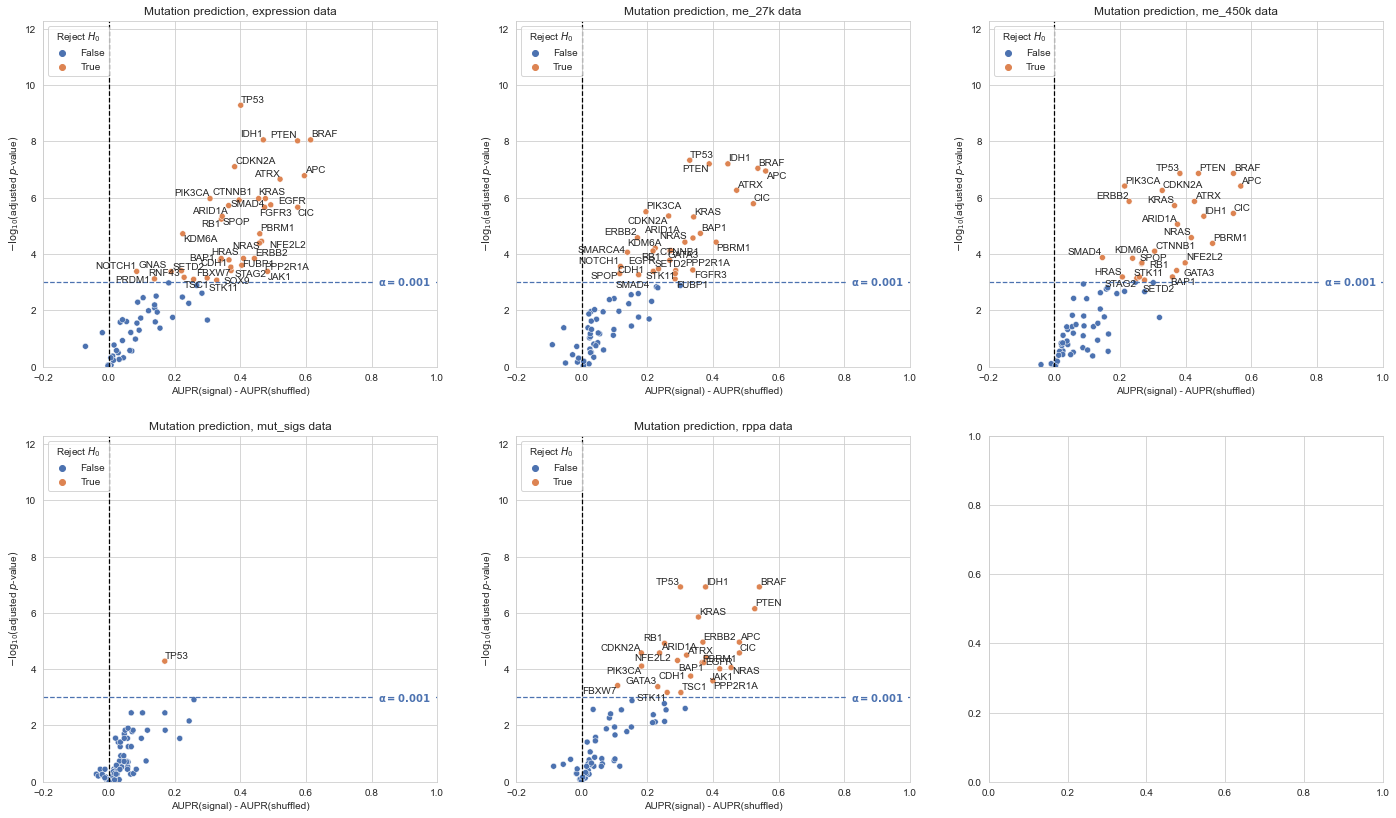

In [7]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

sns.set({'figure.figsize': (24, 14)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, training_data in enumerate(sorted(all_results_df.training_data.unique())):
    ax = axarr[ix // 3, ix % 3]
    data_results_df = all_results_df[all_results_df.training_data == training_data]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)')
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, {} data'.format(training_data))

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(
        training_data,
        np.count_nonzero(data_results_df.reject_null),
        data_results_df.shape[0]
    ))

size 0 results array for CBL, skipping
size 0 results array for GNAQ, skipping


me_27k: 12/95


size 0 results array for GNAQ, skipping


me_450k: 5/95


size 0 results array for CBL, skipping
size 0 results array for GNAQ, skipping


mut_sigs: 39/95


size 0 results array for GNAQ, skipping


rppa: 10/95


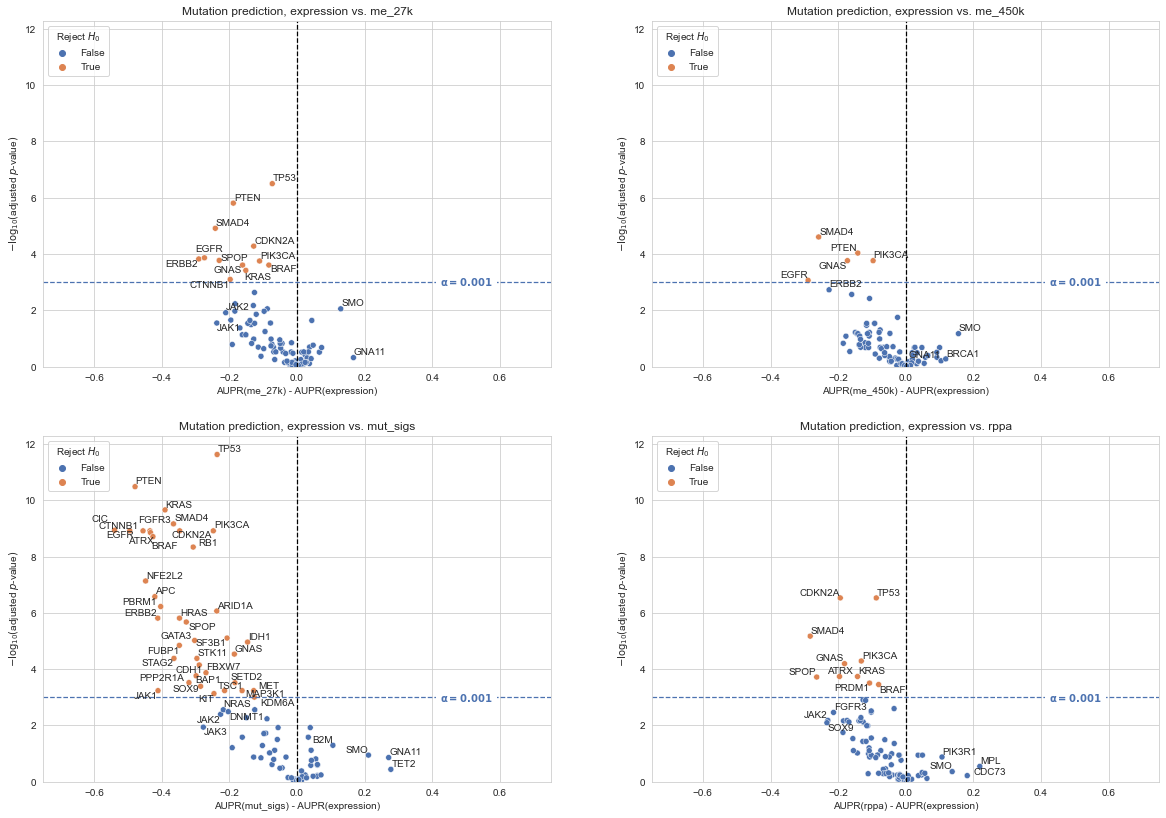

In [8]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if (point['y'] > -np.log10(0.001)) or (point['x'] > 0.1) or (abs(point['x']) > 0.2):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

sns.set({'figure.figsize': (20, 14)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 2)

# all plots should have the same axes for a fair comparison
xlim = (-0.75, 0.75)
# TODO: maybe adjust these afterward?
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

data_types = sorted([dt for dt in all_results_df.training_data.unique() if dt != 'expression'])
exp_results_df = results_df[results_df.training_data == 'expression']

for ix, training_data in enumerate(data_types):
    ax = axarr[ix // 2, ix % 2]
    data_results_df = results_df[results_df.training_data == training_data]
    compare_results_df = au.compare_results(exp_results_df,
                                            pancancer_df=data_results_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
    compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)
    sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)

    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.5, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR({}) - AUPR(expression)'.format(training_data))
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, expression vs. {}'.format(training_data))

    text_labels = label_points(compare_results_df['delta_mean'],
                               compare_results_df['nlog10_p'],
                               compare_results_df.gene,
                               ax)
    adjust_text(text_labels,
                ax=ax,
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(training_data,
                             np.count_nonzero(compare_results_df.reject_null),
                             compare_results_df.shape[0]))